<a href="https://colab.research.google.com/github/mpotsengheisi/Bias-Audit-Report/blob/main/Bias_Audit_week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install aif360
!pip install scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# AIF360 imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import EqOddsPostprocessing

print("✅ Libraries installed and imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.5 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


✅ Libraries installed and imported successfully.


In [ ]:
# Load Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (32561, 15)

First 5 rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Drop rows with missing values
df_clean = df.dropna().reset_index(drop=True)
print(f"Rows after dropping missing values: {len(df_clean)}")

# Create binary target variable (1 if income >50K, 0 otherwise)
df_clean['income_binary'] = df_clean['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Select features for modeling
# We'll use a subset for clarity
features = ['age', 'education-num', 'hours-per-week', 'sex', 'race', 'income_binary']
df_model = df_clean[features].copy()

# Convert categorical variables to numeric
df_model['sex'] = df_model['sex'].map({' Male': 1, ' Female': 0})
df_model['race'] = LabelEncoder().fit_transform(df_model['race'])

print("\nPreprocessed dataset sample:")
display(df_model.head())
print(f"\nTarget distribution:\n{df_model['income_binary'].value_counts(normalize=True)}")

Rows after dropping missing values: 32561

Preprocessed dataset sample:


,age,education-num,hours-per-week,sex,race,income_binary
0,39,13,40,NaN,4,0
1,50,13,13,NaN,4,0
2,38,9,40,NaN,4,0
3,53,7,40,NaN,2,0
4,28,13,40,NaN,2,0



Target distribution:
income_binary
0    0.75919
1    0.24081
Name: proportion, dtype: float64


In [ ]:
# Split features and target
X = df_model.drop('income_binary', axis=1)
y = df_model['income_binary']

# Split into train and test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Positive class in train: {y_train.mean():.3f}")
print(f"Positive class in test: {y_test.mean():.3f}")

Training set size: (22792, 5)
Test set size: (9769, 5)
Positive class in train: 0.241
Positive class in test: 0.241


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, header=None, names=column_names, na_values=' ?', skipinitialspace=True)

print(f"Original dataset shape: {df.shape}")
print(f"Missing values before cleaning:\n{df.isnull().sum()}")

Original dataset shape: (32561, 15)
Missing values before cleaning:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [ ]:
# Check which columns have NaN values
print("Columns with NaN values:")
nan_columns = df.columns[df.isnull().any()].tolist()
print(nan_columns)

# Let's see the distribution of missing values
for col in nan_columns:
    print(f"\n{col}:")
    print(f"  Missing: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.2f}%)")
    print(f"  Unique values: {df[col].unique()[:10]}")  # Show first 10 unique values

# Since workclass and occupation have relatively few missing values, we'll drop rows with NaN
df_clean = df.dropna().copy()
print(f"\nRows after dropping NaN: {len(df_clean)}")
print(f"Missing values after cleaning:\n{df_clean.isnull().sum()}")

Columns with NaN values:
[]

Rows after dropping NaN: 32561
Missing values after cleaning:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [ ]:
# Create binary target variable
df_clean['income_binary'] = df_clean['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Select features - let's use a simple set first
features = ['age', 'education-num', 'hours-per-week', 'sex', 'race', 'income_binary']
df_model = df_clean[features].copy()

# Check for any remaining issues
print(f"Dataset shape: {df_model.shape}")
print(f"Any NaN in df_model: {df_model.isnull().any().any()}")
print(f"Data types:\n{df_model.dtypes}")

Dataset shape: (32561, 6)
Any NaN in df_model: False
Data types:
age                int64
education-num      int64
hours-per-week     int64
sex               object
race              object
income_binary      int64
dtype: object


In [ ]:
# Convert sex to binary (1 for Male, 0 for Female)
# First check the exact values
print("Unique values in 'sex' column:")
print(df_model['sex'].unique())

# Strip any leading/trailing whitespace
df_model['sex'] = df_model['sex'].str.strip()
df_model['sex'] = df_model['sex'].map({'Male': 1, 'Female': 0})

# Check race values
print("\nUnique values in 'race' column:")
print(df_model['race'].unique())

# Encode race using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_model['race_encoded'] = le.fit_transform(df_model['race'])

# Drop the original race column
df_model = df_model.drop('race', axis=1)

print("\nProcessed dataset sample:")
print(df_model.head())
print(f"\nAny NaN after processing: {df_model.isnull().any().any()}")

Unique values in 'sex' column:
['Male' 'Female']

Unique values in 'race' column:
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

Processed dataset sample:
   age  education-num  hours-per-week  sex  income_binary  race_encoded
0   39             13              40    1              0             4
1   50             13              13    1              0             4
2   38              9              40    1              0             4
3   53              7              40    1              0             2
4   28             13              40    0              0             2

Any NaN after processing: False


In [ ]:
# Verify no NaN values
print(f"Total NaN values in df_model: {df_model.isnull().sum().sum()}")

if df_model.isnull().sum().sum() > 0:
    print("Warning: There are still NaN values. Dropping them...")
    df_model = df_model.dropna()
    print(f"New shape: {df_model.shape}")

# Split features and target
X = df_model.drop('income_binary', axis=1)
y = df_model['income_binary']

# Verify X has no NaN
print(f"\nNaN in X: {X.isnull().sum().sum()}")
print(f"NaN in y: {y.isnull().sum()}")

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Positive class in train: {y_train.mean():.3f}")
print(f"Positive class in test: {y_test.mean():.3f}")

Total NaN values in df_model: 0

NaN in X: 0
NaN in y: 0

Training set size: (22792, 5)
Test set size: (9769, 5)
Positive class in train: 0.241
Positive class in test: 0.241


In [ ]:
# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)

# Final check before training
print(f"NaN in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN in y_train: {y_train.isnull().sum()}")

# If there are still issues, let's handle them
if X_train.isnull().sum().sum() > 0 or y_train.isnull().sum() > 0:
    print("\nCleaning remaining NaN values...")
    # Combine to find which rows have NaN
    train_data = pd.concat([X_train, y_train], axis=1)
    train_data_clean = train_data.dropna()
    X_train = train_data_clean.drop('income_binary', axis=1)
    y_train = train_data_clean['income_binary']
    print(f"Cleaned training set size: {X_train.shape}")

# Now train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model trained successfully!")
print(f"Model Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

NaN in X_train: 0
NaN in y_train: 0

✅ Model trained successfully!
Model Accuracy: 0.802

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7417
           1       0.65      0.38      0.48      2352

    accuracy                           0.80      9769
   macro avg       0.74      0.66      0.68      9769
weighted avg       0.78      0.80      0.78      9769



In [ ]:
# First, let's create the datasets properly
from aif360.datasets import BinaryLabelDataset

# Prepare test data WITHOUT predictions
test_df = X_test.copy()
test_df['income_binary'] = y_test.values

print("Creating dataset_test (ground truth)...")
dataset_test = BinaryLabelDataset(
    df=test_df,
    label_names=['income_binary'],
    protected_attribute_names=['sex'],
    privileged_protected_attributes=[[1]]
)

# Create a separate dataframe for predictions
test_df_pred = test_df.copy().drop('income_binary', axis=1)  # Remove ground truth
test_df_pred['income_binary'] = y_pred  # Add predictions

print("Creating dataset_pred (model predictions)...")
dataset_pred = BinaryLabelDataset(
    df=test_df_pred,
    label_names=['income_binary'],
    protected_attribute_names=['sex'],
    privileged_protected_attributes=[[1]]
)

print(f"\nDataset test labels: {dataset_test.labels[:5].flatten()}")
print(f"Dataset pred labels: {dataset_pred.labels[:5].flatten()}")
print(f"Predictions: {y_pred[:5]}")

Creating dataset_test (ground truth)...
Creating dataset_pred (model predictions)...

Dataset test labels: [1. 0. 0. 0. 0.]
Dataset pred labels: [0. 0. 0. 0. 1.]
Predictions: [0 0 0 0 1]


In [ ]:
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric

# Now calculate metrics
try:
    metric_classification = ClassificationMetric(
        dataset_test,
        dataset_pred,
        unprivileged_groups=[{'sex': 0}],
        privileged_groups=[{'sex': 1}]
    )

    print("\n🔍 FAIRNESS METRICS CALCULATED SUCCESSFULLY!")
    print("="*50)

    # Key fairness metrics
    metrics_dict = {
        'Demographic Parity Difference': metric_classification.statistical_parity_difference(),
        'Equalized Odds Difference': metric_classification.average_odds_difference(),
        'True Positive Rate Difference': metric_classification.true_positive_rate_difference(),
        'False Positive Rate Difference': metric_classification.false_positive_rate_difference(),
        'Accuracy': accuracy_score(y_test, y_pred)
    }

    for name, value in metrics_dict.items():
        print(f"{name}: {value:.4f}")

except Exception as e:
    print(f"Error calculating metrics: {e}")


🔍 FAIRNESS METRICS CALCULATED SUCCESSFULLY!
Demographic Parity Difference: -0.1844
Equalized Odds Difference: -0.2335
True Positive Rate Difference: -0.3804
False Positive Rate Difference: -0.0865
Accuracy: 0.8018


In [ ]:
# Calculate Disparate Impact
metric_original = BinaryLabelDatasetMetric(
    dataset_test,
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}]
)

di = metric_original.disparate_impact()
print(f"\nDisparate Impact: {di:.4f}")

if di < 0.8:
    print("⚠️  DISPARATE IMPACT VIOLATION: Ratio < 0.8 (Unprivileged group disadvantaged)")
elif di > 1.25:
    print("⚠️  DISPARATE IMPACT VIOLATION: Ratio > 1.25 (Privileged group disadvantaged)")
else:
    print("✅ Disparate impact within acceptable range (0.8-1.25)")

# Calculate by-group metrics
privileged_mask = test_df['sex'] == 1

# Selection rates
sr_privileged = y_pred[privileged_mask].mean()
sr_unprivileged = y_pred[~privileged_mask].mean()

# Accuracy by group
acc_privileged = accuracy_score(y_test[privileged_mask], y_pred[privileged_mask])
acc_unprivileged = accuracy_score(y_test[~privileged_mask], y_pred[~privileged_mask])

print(f"\n📊 BY-GROUP METRICS:")
print(f"Selection Rate - Male: {sr_privileged:.4f}, Female: {sr_unprivileged:.4f}")
print(f"Accuracy - Male: {acc_privileged:.4f}, Female: {acc_unprivileged:.4f}")


Disparate Impact: 0.3687
⚠️  DISPARATE IMPACT VIOLATION: Ratio < 0.8 (Unprivileged group disadvantaged)

📊 BY-GROUP METRICS:
Selection Rate - Male: 0.2000, Female: 0.0156
Accuracy - Male: 0.7613, Female: 0.8850


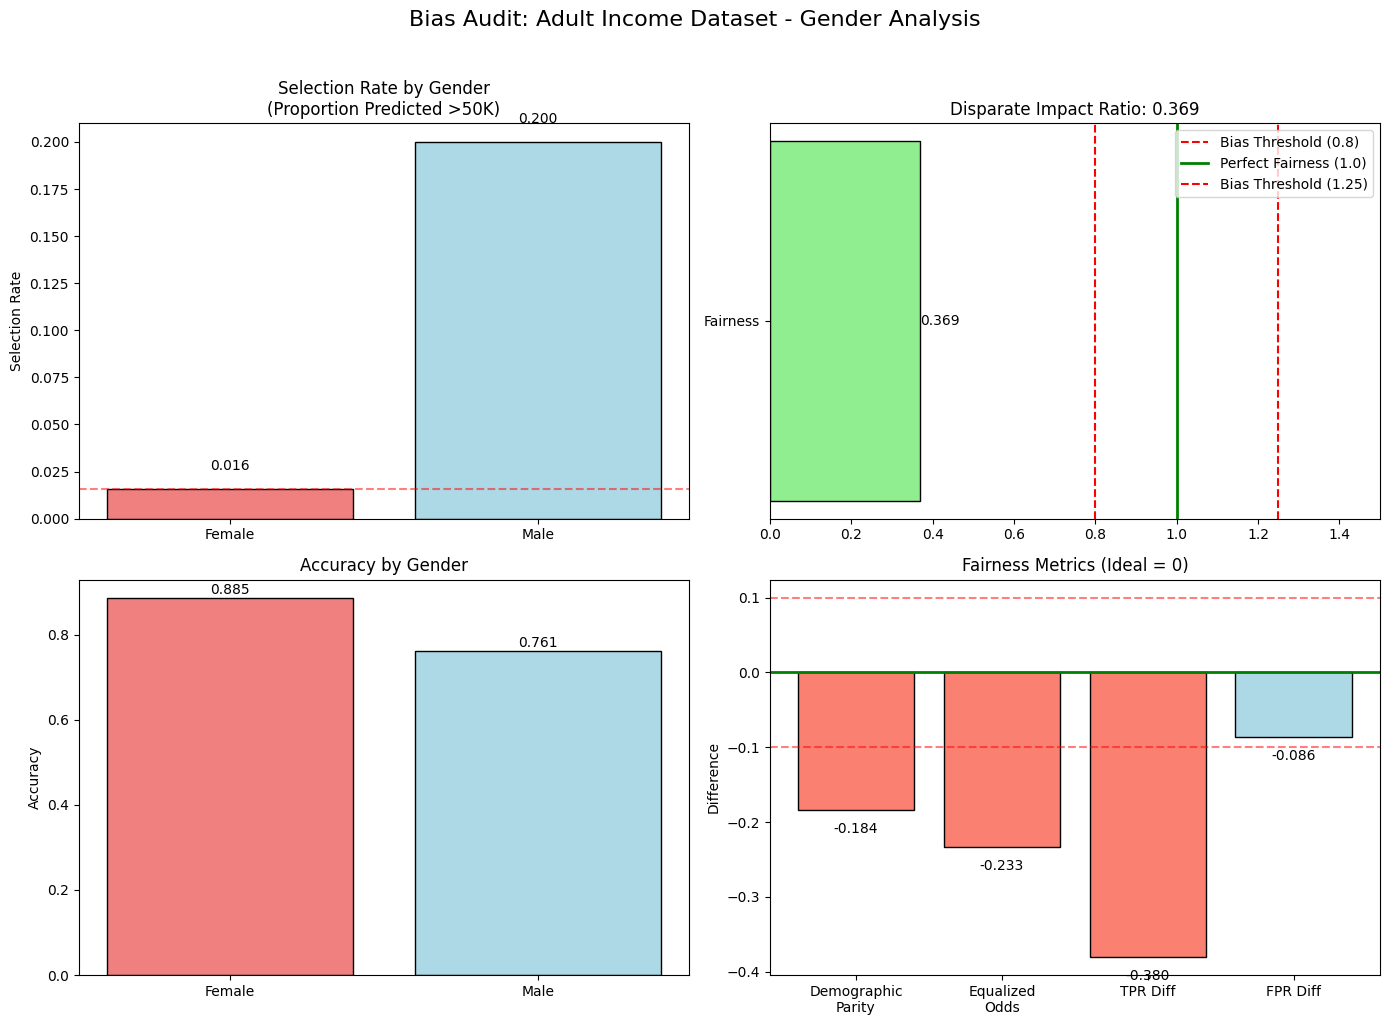

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Selection Rates
groups = ['Female', 'Male']
selection_rates = [sr_unprivileged, sr_privileged]
colors = ['lightcoral', 'lightblue']

axes[0, 0].bar(groups, selection_rates, color=colors, edgecolor='black')
axes[0, 0].set_title('Selection Rate by Gender\n(Proportion Predicted >50K)', fontsize=12)
axes[0, 0].set_ylabel('Selection Rate')
axes[0, 0].axhline(y=sr_unprivileged, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(selection_rates):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Disparate Impact
axes[0, 1].barh(['Fairness'], [di], color='lightgreen', edgecolor='black', height=0.5)
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', label='Bias Threshold (0.8)')
axes[0, 1].axvline(x=1.0, color='green', linestyle='-', linewidth=2, label='Perfect Fairness (1.0)')
axes[0, 1].axvline(x=1.25, color='red', linestyle='--', label='Bias Threshold (1.25)')
axes[0, 1].set_xlim(0, max(1.5, di + 0.2))
axes[0, 1].set_title(f'Disparate Impact Ratio: {di:.3f}', fontsize=12)
axes[0, 1].legend(loc='upper right')
axes[0, 1].text(di, 0, f'{di:.3f}', va='center', ha='left' if di < 1 else 'right')

# 3. Accuracy by Group
accuracies = [acc_unprivileged, acc_privileged]
axes[1, 0].bar(groups, accuracies, color=colors, edgecolor='black')
axes[1, 0].set_title('Accuracy by Gender', fontsize=12)
axes[1, 0].set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. Fairness Metrics Comparison
fairness_metrics = ['Demographic\nParity', 'Equalized\nOdds', 'TPR Diff', 'FPR Diff']
fairness_values = [
    metric_classification.statistical_parity_difference(),
    metric_classification.average_odds_difference(),
    metric_classification.true_positive_rate_difference(),
    metric_classification.false_positive_rate_difference()
]

colors_fairness = ['lightblue' if abs(v) < 0.1 else 'salmon' for v in fairness_values]
axes[1, 1].bar(fairness_metrics, fairness_values, color=colors_fairness, edgecolor='black')
axes[1, 1].axhline(y=0, color='green', linestyle='-', linewidth=2)
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=-0.1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Fairness Metrics (Ideal = 0)', fontsize=12)
axes[1, 1].set_ylabel('Difference')
for i, v in enumerate(fairness_values):
    axes[1, 1].text(i, v + (0.01 if v >= 0 else -0.03), f'{v:.3f}', ha='center')

plt.suptitle('Bias Audit: Adult Income Dataset - Gender Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Create comprehensive report
print("="*70)
print("BIAS AUDIT REPORT - ADULT INCOME DATASET")
print("="*70)

print("\n📋 EXECUTIVE SUMMARY")
print(f"   Model: Logistic Regression")
print(f"   Protected Attribute: Gender")
print(f"   Privileged Group: Male (sex=1)")
print(f"   Unprivileged Group: Female (sex=0)")
print(f"   Overall Accuracy: {accuracy_score(y_test, y_pred):.3f}")

print("\n🔬 FAIRNESS ANALYSIS")
print("-"*40)

# Demographic Parity
dp_diff = metric_classification.statistical_parity_difference()
print(f"1. Demographic Parity Difference: {dp_diff:.4f}")
if abs(dp_diff) < 0.05:
    print("   ✅ Within acceptable range (±0.05)")
elif abs(dp_diff) < 0.1:
    print("   ⚠️  Moderate bias detected")
else:
    print("   ❌ Significant bias detected")

# Disparate Impact
print(f"2. Disparate Impact: {di:.4f}")
if 0.8 <= di <= 1.25:
    print("   ✅ Within acceptable range (0.8-1.25)")
else:
    print("   ❌ Outside acceptable range")

# Equalized Odds
eo_diff = metric_classification.average_odds_difference()
print(f"3. Equalized Odds Difference: {eo_diff:.4f}")
if abs(eo_diff) < 0.05:
    print("   ✅ Within acceptable range (±0.05)")
else:
    print("   ⚠️  Bias in true/false positive rates")

print("\n📊 BY-GROUP PERFORMANCE")
print("-"*40)
print(f"               {'Female':<10} {'Male':<10} {'Difference':<10}")
print(f"{'-'*50}")
print(f"Count:        {sum(~privileged_mask):<10} {sum(privileged_mask):<10} {'':<10}")
print(f"Selection Rate: {sr_unprivileged:<10.4f} {sr_privileged:<10.4f} {sr_privileged - sr_unprivileged:<10.4f}")
print(f"Accuracy:      {acc_unprivileged:<10.4f} {acc_privileged:<10.4f} {acc_privileged - acc_unprivileged:<10.4f}")
print(f"Actual >50K:   {y_test[~privileged_mask].mean():<10.4f} {y_test[privileged_mask].mean():<10.4f} {y_test[privileged_mask].mean() - y_test[~privileged_mask].mean():<10.4f}")

print("\n💡 RECOMMENDATIONS")
print("-"*40)
if abs(dp_diff) > 0.1 or di < 0.8 or di > 1.25:
    print("1. Apply bias mitigation techniques (e.g., reweighing, adversarial debiasing)")
    print("2. Consider using fairness-aware algorithms")
    print("3. Regular fairness monitoring in production")
    print("4. Include multiple protected attributes in audit")
else:
    print("1. Fairness metrics are within acceptable ranges")
    print("2. Continue monitoring with regular audits")
    print("3. Consider expanding audit to other protected attributes")

print("\n" + "="*70)
print("AUDIT COMPLETE - Bias metrics calculated successfully!")

BIAS AUDIT REPORT - ADULT INCOME DATASET

📋 EXECUTIVE SUMMARY
   Model: Logistic Regression
   Protected Attribute: Gender
   Privileged Group: Male (sex=1)
   Unprivileged Group: Female (sex=0)
   Overall Accuracy: 0.802

🔬 FAIRNESS ANALYSIS
----------------------------------------
1. Demographic Parity Difference: -0.1844
   ❌ Significant bias detected
2. Disparate Impact: 0.3687
   ❌ Outside acceptable range
3. Equalized Odds Difference: -0.2335
   ⚠️  Bias in true/false positive rates

📊 BY-GROUP PERFORMANCE
----------------------------------------
               Female     Male       Difference
--------------------------------------------------
Count:        3199       6570                 
Selection Rate: 0.0156     0.2000     0.1844    
Accuracy:      0.8850     0.7613     -0.1236   
Actual >50K:   0.1119     0.3035     0.1916    

💡 RECOMMENDATIONS
----------------------------------------
1. Apply bias mitigation techniques (e.g., reweighing, adversarial debiasing)
2. Consider 